In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[4]').appName('spark_ml').getOrCreate()

In [ ]:
import pyspark.sql.types as types
import pyspark.ml.feature as ft
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils
import numpy as np
import pyspark.sql.functions as fn
import pandas as pd
from pyspark.sql import Row
from pyspark import SparkContext as sc
import matplotlib.pyplot as plt
import pyspark.ml.classification as cl

In [ ]:
df = spark.read.csv('FINALseagate.csv', header=True, inferSchema = True)

df.printSchema()

root
 |-- DAF_LIFE_CYCLE_NUM: integer (nullable = true)
 |-- PARAM_002_MEDIAN: double (nullable = true)
 |-- PARAM_009_MEDIAN: double (nullable = true)
 |-- PARAM_010_MEDIAN: double (nullable = true)
 |-- PARAM_018_MEDIAN: double (nullable = true)
 |-- PARAM_021_MEDIAN: double (nullable = true)
 |-- PARAM_022_MEDIAN: double (nullable = true)
 |-- PARAM_025_MEDIAN: double (nullable = true)
 |-- PARAM_026_MEDIAN: double (nullable = true)
 |-- PARAM_027_MEDIAN: double (nullable = true)
 |-- PARAM_028_MEDIAN: integer (nullable = true)
 |-- PARAM_029_MEDIAN: integer (nullable = true)
 |-- PARAM_030_MEDIAN: integer (nullable = true)
 |-- PARAM_039_MEDIAN: integer (nullable = true)
 |-- PARAM_043_MEDIAN: double (nullable = true)
 |-- PARAM_054_MEDIAN: double (nullable = true)
 |-- PARAM_055_MEDIAN: double (nullable = true)
 |-- PARAM_059_MEDIAN: double (nullable = true)
 |-- PARAM_071_MEDIAN: integer (nullable = true)
 |-- PARAM_072_MEDIAN: integer (nullable = true)
 |-- PARAM_073_MEDIAN: int

In [ ]:
cols = df.drop('TARGET','FAD_MBA_PART_NUM','FAD_MEDIA_PART_NUM').columns

#df_e=df_e.drop('features')
df_v = ft.VectorAssembler(inputCols=[col for col in cols], outputCol='features').transform(df) 

In [ ]:
#df_e=df_e.drop('scaled_features')
scaler = ft.StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
df_ss = scaler.fit(df_v).transform(df_v)

## K Means

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score2=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,20):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(df_v)
    
    output=KMeans_fit.transform(df_v)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score2.append(score)
    
    print("Silhouette Score:",score)

In [ ]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),silhouette_score2)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [ ]:
df_ss = df_ss.withColumn("idx", fn.monotonically_increasing_id())

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

k = 2
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")
model = kmeans.fit(df_ss)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-1.10568157e-02  1.34843725e-02 -1.04165171e-02 -1.07746528e-02
 -1.82602199e-02 -5.35942898e-03 -1.59187558e-02 -1.92205419e-03
 -3.21163442e-03 -1.70558380e-02 -8.81915530e-03 -6.46422412e-02
  2.19091126e-02 -6.63283877e-02  3.55648284e-03 -1.23584312e-02
  1.49290632e-03 -7.66098439e-03  6.68002717e-04 -1.11116874e-02
  7.54137867e-04  1.98849887e-02  1.59907224e-02 -1.09136177e-02
 -9.60715084e-03 -6.06493694e-02 -4.61885312e-02 -4.44842920e-02
 -3.98679304e-03 -1.37413704e-02  9.15865457e-03  7.60859348e-03
 -3.74162031e-02 -2.39044254e-02  8.40289097e-03 -4.16010105e-02
  3.70695648e-02  1.10310233e-02  2.19313502e-02  1.77222300e-02
  5.36477363e-02 -5.45637179e-02  7.87159762e-03  2.90631725e-04
 -4.19009058e-01 -4.59656757e-03  4.19077903e-01 -7.54482487e-02
  7.54482487e-02  2.40856690e-03  3.60244610e-03 -7.50485651e-02
  7.48556008e-02 -1.17053363e-03  1.70113831e-02  1.33078735e-02
 -7.71346423e-02  1.59010531e-01 -9.46546529e-02 -7.80095966e-02
  8.505

In [ ]:
predictions = model.transform(df_ss)
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)

Silhouette with squared euclidean distance = 0.17330592905654787
Cluster Centers: 
[-1.10568157e-02  1.34843725e-02 -1.04165171e-02 -1.07746528e-02
 -1.82602199e-02 -5.35942898e-03 -1.59187558e-02 -1.92205419e-03
 -3.21163442e-03 -1.70558380e-02 -8.81915530e-03 -6.46422412e-02
  2.19091126e-02 -6.63283877e-02  3.55648284e-03 -1.23584312e-02
  1.49290632e-03 -7.66098439e-03  6.68002717e-04 -1.11116874e-02
  7.54137867e-04  1.98849887e-02  1.59907224e-02 -1.09136177e-02
 -9.60715084e-03 -6.06493694e-02 -4.61885312e-02 -4.44842920e-02
 -3.98679304e-03 -1.37413704e-02  9.15865457e-03  7.60859348e-03
 -3.74162031e-02 -2.39044254e-02  8.40289097e-03 -4.16010105e-02
  3.70695648e-02  1.10310233e-02  2.19313502e-02  1.77222300e-02
  5.36477363e-02 -5.45637179e-02  7.87159762e-03  2.90631725e-04
 -4.19009058e-01 -4.59656757e-03  4.19077903e-01 -7.54482487e-02
  7.54482487e-02  2.40856690e-03  3.60244610e-03 -7.50485651e-02
  7.48556008e-02 -1.17053363e-03  1.70113831e-02  1.33078735e-02
 -7.713

## Logistic

In [ ]:
trainv, testv = df_v.randomSplit([0.7, 0.3], seed = 1)
trains, tests = df_ss.randomSplit([0.7, 0.3], seed = 1)

In [ ]:
logistic = cl.LogisticRegression(maxIter=10,featuresCol = 'features',labelCol='TARGET')
modelv = logistic.fit(trainv)
test_modelv = modelv.transform(testv)

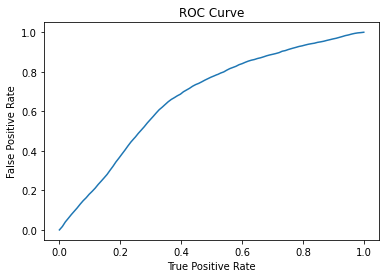

Training set areaUnderROC: 0.6726048634260444


In [ ]:
trainingSummaryv = modelv.summary
roc = trainingSummaryv.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummaryv.areaUnderROC))

In [ ]:
import pyspark.ml.evaluation as ev

evaluatorv = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='TARGET')

print(evaluatorv.evaluate(test_modelv, {evaluatorv.metricName: 'areaUnderROC'}))

0.6834114505548127


In [ ]:
logistic = cl.LogisticRegression(maxIter=10,featuresCol = 'scaled_features',labelCol='TARGET')
models = logistic.fit(trains)
test_models = models.transform(tests)

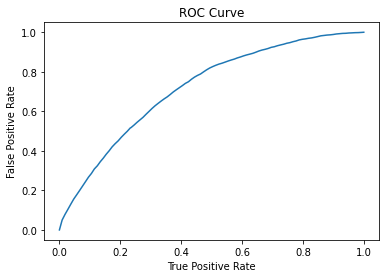

Training set areaUnderROC: 0.7183816435842862


In [ ]:
trainingSummarys = models.summary
roc = trainingSummarys.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummarys.areaUnderROC))

In [ ]:
evaluators = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='TARGET')

print(evaluators.evaluate(test_models, {evaluators.metricName: 'areaUnderROC'}))

0.7178009459396704


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

preds_and_labels = test_models.select(['prediction','TARGET']).withColumn('label', fn.col('TARGET').cast(types.FloatType())).orderBy('prediction')

preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[8.6422e+04 2.0000e+00]
 [2.3280e+03 0.0000e+00]]


## Random Forest

In [ ]:
df_v = df_v.withColumn('TARGET', fn.col('TARGET').cast(types.DoubleType()))

In [ ]:
df_ss = df_ss.withColumn('TARGET', fn.col('TARGET').cast(types.DoubleType()))

In [ ]:
trainv, testv = df_v.randomSplit([0.7, 0.3], seed = 1)
trains, tests = df_ss.randomSplit([0.7, 0.3], seed = 1)

In [ ]:
classifier = cl.RandomForestClassifier(numTrees=5, maxDepth=5, featuresCol = 'features', labelCol='TARGET')
modelv = classifier.fit(trainv)
testv = modelv.transform(testv)

In [ ]:
print(evaluatorv.evaluate(testv, {evaluatorv.metricName: "areaUnderROC"}))

0.6492405962110245


In [ ]:
classifier = cl.RandomForestClassifier(numTrees=5, maxDepth=5, featuresCol = 'scaled_features', labelCol='TARGET')
models = classifier.fit(trains)
tests = models.transform(tests)

In [ ]:
print(evaluators.evaluate(tests, {evaluators.metricName: "areaUnderROC"}))

0.674828799981741


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

preds_and_labels = tests.select(['prediction','TARGET']).withColumn('label', fn.col('TARGET').cast(types.FloatType())).orderBy('prediction')

preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[86424.     0.]
 [ 2328.     0.]]


## GBT

In [ ]:
trainv, testv = df_v.randomSplit([0.7, 0.3], seed = 1)
trains, tests = df_ss.randomSplit([0.7, 0.3], seed = 1)

In [ ]:
gbtv = cl.GBTClassifier(maxIter=10, labelCol='TARGET',featuresCol = 'features')
gbtModelv = gbtv.fit(trainv)
predictionsv = gbtModelv.transform(testv)

In [ ]:
import pyspark.ml.evaluation as ev
evaluatorv = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='TARGET')
evaluators = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='TARGET')

In [ ]:
print(evaluatorv.evaluate(predictionsv, {evaluatorv.metricName: "areaUnderROC"}))

0.7490278588930847


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGridv = (ParamGridBuilder()
             .addGrid(gbtv.maxDepth, [2, 4, 6])
             .addGrid(gbtv.maxBins, [20, 60])
             .addGrid(gbtv.maxIter, [10, 20])
             .build())
cvv = CrossValidator(estimator=gbtv, estimatorParamMaps=paramGridv, evaluator=evaluatorv, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModelv = cvv.fit(trainv)
predictionsv = cvModelv.transform(testv)
evaluatorv.evaluate(predictionsv)

0.7724522298438801

In [ ]:
gbts = cl.GBTClassifier(maxIter=10, labelCol='TARGET',featuresCol = 'scaled_features')
gbtModels = gbts.fit(trains)
predictionss = gbtModels.transform(tests)

In [ ]:
print(evaluators.evaluate(predictionss, {evaluators.metricName: "areaUnderROC"}))

0.7488846197982426


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrids = (ParamGridBuilder()
             .addGrid(gbts.maxDepth, [2, 4, 6])
             .addGrid(gbts.maxBins, [20, 60])
             .addGrid(gbts.maxIter, [10, 20])
             .build())
cvs = CrossValidator(estimator=gbts, estimatorParamMaps=paramGrids, evaluator=evaluators, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModels = cvs.fit(trains)
predictionss = cvModels.transform(tests)
evaluators.evaluate(predictionss)

0.7735806322333781

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

preds_and_labels = predictionss.select(['prediction','TARGET']).withColumn('label', fn.col('TARGET').cast(types.FloatType())).orderBy('prediction')

preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[8.6404e+04 2.0000e+01]
 [2.3240e+03 4.0000e+00]]


In [ ]:
print(metrics.confusionMatrix())
print(metrics.precision(0.0))
print(metrics.recall(0.0))

DenseMatrix([[8.6404e+04, 2.0000e+01],
             [2.3240e+03, 4.0000e+00]])
0.9738075917410512
0.9997685828010737
